# Lyrics detector Challenge

The goal for this challenge is to leverage your knowledge of Deep Learning to design and train a lyrics classifier. For a given verse $X$, our model should learn to predict the artist $y$. The dataset consists of lyrics scrapped from the Genius website.

### Objectives:
- Text preprocessing
- Text embedding
- Train a RNN to detect the artist behind a set of lyrics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode
import tensorflow as tf

## 1. Data Cleaning

Our dataset contains around 4,000 verses of lyrics from different artists: Drake, Ed Sheeran and Kanye West (the verses are given in this order).

In [2]:
raw_data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/verses.csv")
data = raw_data.copy() # From now on, update `data` as you see fit and don't touch raw_data
data

,artist,verse
0,Drake,"Ayy, woah Ayy, ayy Yeah"
1,Drake,I'm makin' a change today The liquor been taki...
2,Drake,"I can't just be with you and only you Yeah, I ..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne..."
4,Drake,I'm makin' a change today The liquor been taki...
...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol..."
3971,Kanye West,"Then one day I just went ahead and played it, ..."
3972,Kanye West,"""I ain't gonna front, it's kinda hot."""
3973,Kanye West,Like they still weren't looking at me like a r...


❓ **Have a look at the verse index 18th**. 
- What do you observe?
- Clean verses from non standard characters using [`unidecode.unidecode()`](https://pypi.org/project/Unidecode/)

In [3]:
# YOUR CODE HERE
data['verse'].loc[18]

'Ayy, yeah Pipe this shit up and I turn this shit up When I was down, I\u2005was\u2005down Now them diamonds\u2005for fun like damn Ayy, yeah'

In [4]:
unidecode(data['verse'].loc[18])

'Ayy, yeah Pipe this shit up and I turn this shit up When I was down, I was down Now them diamonds for fun like damn Ayy, yeah'

In [5]:
data['verse'] = data['verse'].apply(lambda x: unidecode(x))
data

,artist,verse
0,Drake,"Ayy, woah Ayy, ayy Yeah"
1,Drake,I'm makin' a change today The liquor been taki...
2,Drake,"I can't just be with you and only you Yeah, I ..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne..."
4,Drake,I'm makin' a change today The liquor been taki...
...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol..."
3971,Kanye West,"Then one day I just went ahead and played it, ..."
3972,Kanye West,"""I ain't gonna front, it's kinda hot."""
3973,Kanye West,Like they still weren't looking at me like a r...


❓ **Check if some verses are duplicated.** 
- It can be frequent in music lyrics.
- If so, remove them to avoid data leaks between train and test sets

In [6]:
# YOUR CODE HERE
data.duplicated().value_counts()

False    3031
True      944
dtype: int64

In [7]:
data = data.drop_duplicates()
data.shape

(3031, 2)

In [8]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_loading',
    shape=data.shape,
    verses=data.verse[:50]
)

result.write()

## 2. Data Analysis (given to you)

👉 **We check the number of unique artist and the number of verses per artist**

In [9]:
data.artist.value_counts()

Drake         1391
Ed Sheeran     861
Kanye West     779
Name: artist, dtype: int64

👉 **For each artist, let's have a look at the top-10 most used words to see if they look similar?**

We'll use Tensorflow's [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)'s index_word

In [10]:
drake = data[data.artist =='Drake'].verse
ed = data[data.artist =='Ed Sheeran'].verse
kanye = data[data.artist =='Kanye West'].verse

In [11]:
tokenizer_drake = tf.keras.preprocessing.text.Tokenizer()
tokenizer_ed = tf.keras.preprocessing.text.Tokenizer()
tokenizer_kanye = tf.keras.preprocessing.text.Tokenizer()

tokenizer_drake.fit_on_texts(drake)
tokenizer_ed.fit_on_texts(ed)
tokenizer_kanye.fit_on_texts(kanye)

In [12]:
pd.DataFrame(data={
    "Drake": pd.Series(tokenizer_drake.index_word)[:10],
    "Ed Sheeran": pd.Series(tokenizer_ed.index_word)[:10],
    "Kanye West": pd.Series(tokenizer_kanye.index_word)[:10],
})

,Drake,Ed Sheeran,Kanye West
1,i,i,i
2,you,you,the
3,the,the,you
4,and,and,and
5,to,me,to
6,a,my,a
7,it,to,my
8,me,a,it
9,i'm,in,me
10,my,i'm,in


👉 **Let's quantify how much vocabulary do they have in common**

- An artist **vocabulary** is the **set** of all unique used words
- We compute the `ratio` of (i) the length of vocabulary they **share**, over (ii) the length of the **total** vocabulary of the dataset

<details>
    <summary>Hints</summary>

We'll use Python [`set.intersection()`](https://www.programiz.com/python-programming/methods/set/intersection) and [`set.union()`](https://www.programiz.com/python-programming/methods/set/union)
</details>

In [13]:
drake_vocabulary = set(tokenizer_drake.index_word.values())
ed_vocabulary = set(tokenizer_ed.index_word.values())
kanye_vocabulary = set(tokenizer_kanye.index_word.values())

In [14]:
common_vocabulary = drake_vocabulary.intersection(ed_vocabulary).intersection(kanye_vocabulary)
global_vocabulary = drake_vocabulary.union(ed_vocabulary).union(kanye_vocabulary)

ratio = len(common_vocabulary)/len(global_vocabulary)
print(f"{ratio*100:.2f}% of the artists' vocabulary is common")

15.28% of the artists' vocabulary is common


## 3. Data Preprocessing

### 3.1 Word Embedding
We now need to think about embedding our sentences into numbers. We will be using [`gensim.models.Word2Vec`](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) to embed each word of the sentence and concatenate the embeddings of the words forming the sentence.

❓ **Transform the list of strings (verses) into a list of word sequences (a word sequence is a list of words contained in a string)**
- Store these sequences of words in a new column `data["seq"]` in your dataframe
- You can use `tensorflow.keras.preprocessing.text.text_to_word_sequence` 

In [15]:
data

,artist,verse
0,Drake,"Ayy, woah Ayy, ayy Yeah"
1,Drake,I'm makin' a change today The liquor been taki...
2,Drake,"I can't just be with you and only you Yeah, I ..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne..."
4,Drake,I'm makin' a change today The liquor been taki...
...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol..."
3971,Kanye West,"Then one day I just went ahead and played it, ..."
3972,Kanye West,"""I ain't gonna front, it's kinda hot."""
3973,Kanye West,Like they still weren't looking at me like a r...


In [16]:
# YOUR CODE HERE
data["seq"] = data['verse'].apply(lambda x: tf.keras.preprocessing.text.text_to_word_sequence(x, lower=True, split=' '))

<ipython-input-16-b3499b1f25ee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["seq"] = data['verse'].apply(lambda x: tf.keras.preprocessing.text.text_to_word_sequence(x, lower=True, split=' '))


In [17]:
data

,artist,verse,seq
0,Drake,"Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]"
1,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b..."
2,Drake,"I can't just be with you and only you Yeah, I ...","[i, can't, just, be, with, you, and, only, you..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne...","[well, summer, all, i, did, was, rest, okay, a..."
4,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b..."
...,...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol...","[dame, was, like, yo, you, got, a, deal, with,..."
3971,Kanye West,"Then one day I just went ahead and played it, ...","[then, one, day, i, just, went, ahead, and, pl..."
3972,Kanye West,"""I ain't gonna front, it's kinda hot.""","[i, ain't, gonna, front, it's, kinda, hot]"
3973,Kanye West,Like they still weren't looking at me like a r...,"[like, they, still, weren't, looking, at, me, ..."


❓ **Let's check if we can cap the length of each sequences without losing too much information**
- Plot the distribution of sequences lengths using the [`seaborn.kdeplot`](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn-displot) function
- Does it seem reasonable to limit ourself to 300 words per verse later on? 

<AxesSubplot:xlabel='seq', ylabel='Density'>

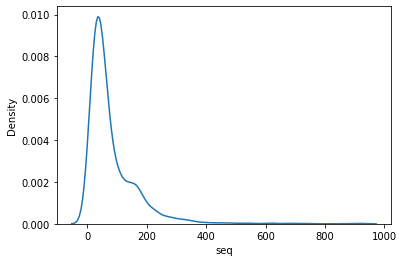

In [18]:
# YOUR CODE HERE
lenghts = data['seq'].apply(lambda x: len(x))
sns.kdeplot(lenghts)

yes, if we look at the plot, it seem reasonable to limit ourself to 300 words per verse later on

❓ **Keep only the first `300` words of each sequences to reduce the useless long tail of long verses**

In [19]:
# YOUR CODE HERE
data['seq'] = data['seq'].apply(lambda x: x[:300])

<ipython-input-19-5515bdcfe29f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['seq'] = data['seq'].apply(lambda x: x[:300])


<AxesSubplot:xlabel='seq', ylabel='Density'>

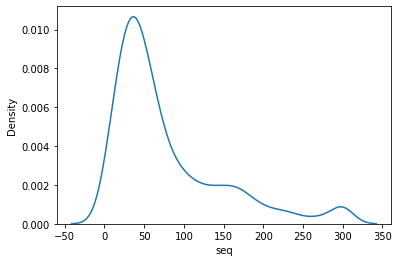

In [20]:
lenghts = data['seq'].apply(lambda x: len(x))
sns.kdeplot(lenghts)

❓ **Train a `gensim.models.Word2Vec` model on your dataset** 
- You want to embed each word into vectors of dimension `100`
- No words should be excluded
- Give Word2Vec at least 50 epochs to be sure it converges
- Store these lists of vectors in a new column `data["embed"]`

In [21]:
# YOUR CODE HERE
from gensim.models import Word2Vec

X_train = data['seq']
word2vec = Word2Vec(sentences=X_train, vector_size=100, min_count=0, epochs=50)
wv = word2vec.wv

/home/tom/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [22]:
data["embed"] = data['seq'].apply(lambda x: wv[x])

<ipython-input-22-8ccbc4e802e7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["embed"] = data['seq'].apply(lambda x: wv[x])


In [23]:
# Check 
assert len(data['embed']) == len(data)

### 3.2 Create (X,y)

❓ **Create your numpy array `X` of shape (number_of_verses, 300, 100)**

- 300 words per verse (pad verses shorter than 300 with zeros at the end) 
- each words being a vector of size 100

<img src="https://raw.githubusercontent.com/lewagon/data-images/master/DL/padding.png" width=400>

In [24]:
# YOUR CODE HERE
from tensorflow.keras.preprocessing.sequence import pad_sequences

sequence = data["embed"]
X = tf.keras.preprocessing.sequence.pad_sequences(sequence, padding='post')
X.shape

(3031, 300, 100)

❓ **Create the numpy array `y` of shape `(n_verses, 3)` that contains the one-hot-encoded list of labels, for the RNN**

In [25]:
data['artist'].unique()

array(['Drake', 'Ed Sheeran', 'Kanye West'], dtype=object)

In [26]:
# YOUR CODE HERE
from sklearn.preprocessing import OneHotEncoder

embed_encoder = OneHotEncoder(sparse=False) # Instanciate encoder

embed_encoder.fit(data[['artist']]) # Fit one hot encoder

embed_encoder.categories_ # View categories of GarageFinish

data['Drake'],data['Ed Sheeran'],data['Kanye West']  = embed_encoder.fit_transform(data[['artist']]).T # Put encoded columns back in dataframe

data.head()

<ipython-input-26-71552e588e35>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Drake'],data['Ed Sheeran'],data['Kanye West']  = embed_encoder.fit_transform(data[['artist']]).T # Put encoded columns back in dataframe


,artist,verse,seq,embed,Drake,Ed Sheeran,Kanye West
0,Drake,"Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]","[[-0.38374585, -0.0049439548, -0.6768495, -1.2...",1.0,0.0,0.0
1,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b...","[[0.6020111, -3.369704, -3.712818, 1.4482266, ...",1.0,0.0,0.0
2,Drake,"I can't just be with you and only you Yeah, I ...","[i, can't, just, be, with, you, and, only, you...","[[1.270247, 0.48878238, -0.46426147, -0.498297...",1.0,0.0,0.0
3,Drake,"Well, summer, all I did was rest, okay? And Ne...","[well, summer, all, i, did, was, rest, okay, a...","[[0.06203421, -0.38194844, -1.2767656, 0.47923...",1.0,0.0,0.0
4,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b...","[[0.6020111, -3.369704, -3.712818, 1.4482266, ...",1.0,0.0,0.0


In [27]:
y = data[['Drake', 'Ed Sheeran', 'Kanye West']].to_numpy()
y.shape

(3031, 3)

👉 We train/test split the dataset below for you

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [29]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_preprocessing',
    n_zeros = np.sum(X == 0),
    X_shape = X.shape,
    y_shape = y.shape,
)

result.write()

## 4. Recurrent Neural Network

👉 Run this code below if you haven't managed to build your own (X,Y) training sets. This will load them as solution

```python
! wget \
'https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle'

import pickle
with open("data_lyrics_solution.pickle", "rb") as file:
    (X_train, y_train, X_test, y_test) = pickle.load(file)
    
! rm data_lyrics_solution.pickle
```

In [30]:
! wget \
'https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle'

import pickle
with open("data_lyrics_solution.pickle", "rb") as file:
    (X_train, y_train, X_test, y_test) = pickle.load(file)

! rm data_lyrics_solution.pickle

--2021-06-29 17:55:27--  https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle
Resolving wagon-public-datasets.s3.amazonaws.com (wagon-public-datasets.s3.amazonaws.com)... 52.218.25.162
Connecting to wagon-public-datasets.s3.amazonaws.com (wagon-public-datasets.s3.amazonaws.com)|52.218.25.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 727513032 (694M) [application/octet-stream]
Saving to: ‘data_lyrics_solution.pickle’

data_lyrics_solutio 100%[===================>] 693,81M  31,8MB/s    in 20s     

2021-06-29 17:55:47 (34,6 MB/s) - ‘data_lyrics_solution.pickle’ saved [727513032/727513032]



❓ **First, store your baseline accuracy to beat as `score_baseline`**
- Consider predicting always the most frequent artist

In [31]:
# YOUR CODE HERE
data['artist'].value_counts()

Drake         1391
Ed Sheeran     861
Kanye West     779
Name: artist, dtype: int64

In [32]:
data['artist'].shape

(3031,)

In [33]:
score_baseline = 1391/3031
score_baseline

0.45892444737710325

❓ **Create a RNN architecture to predict the artists `y`  given verses `X`** :

- Keep it simple: use only one LSTM layer and one *hidden* dense layer between the input and output layers
- Don't forget to take care of fake "zeros" added during preprocessing
- Store it into the `model` variable.

In [34]:
# YOUR CODE HERE
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import callbacks

def init_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(units=20, activation='tanh'))
    model.add(layers.Dense(10, activation="tanh"))
    model.add(layers.Dense(3, activation="softmax"))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics='accuracy')
    return model

model = init_model()

❓ **Train your `model` on the `(X_train, y_train)` training set**
- Use an appropriate loss
- Adapt the learning rate of your optimizer if convergence is too slow/fast
- Make sure your model does not overfit with appropriate control techniques

💡 You will not be judged by the computing power of your computer, you can reach decent performance in less than 3 minutes of training without GPUs.

In [35]:
# YOUR CODE HERE
es = callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                  epochs=10,
                  batch_size=32,
                  validation_split=0.2,
                  callbacks=[es],
                  verbose=1)

Epoch 1/10
61/61 [==============================] - 9s 100ms/step - loss: 1.0267 - accuracy: 0.4930 - val_loss: 1.0072 - val_accuracy: 0.5010
Epoch 2/10
61/61 [==============================] - 5s 90ms/step - loss: 0.9269 - accuracy: 0.5807 - val_loss: 0.9426 - val_accuracy: 0.5588
Epoch 3/10
61/61 [==============================] - 7s 116ms/step - loss: 0.8420 - accuracy: 0.6328 - val_loss: 0.9057 - val_accuracy: 0.5670
Epoch 4/10
61/61 [==============================] - 6s 95ms/step - loss: 0.7673 - accuracy: 0.6772 - val_loss: 0.8600 - val_accuracy: 0.5979
Epoch 5/10
61/61 [==============================] - 5s 86ms/step - loss: 0.6944 - accuracy: 0.7107 - val_loss: 0.8419 - val_accuracy: 0.6186
Epoch 6/10
61/61 [==============================] - 5s 82ms/step - loss: 0.6294 - accuracy: 0.7494 - val_loss: 0.8407 - val_accuracy: 0.6433
Epoch 7/10
61/61 [==============================] - 5s 81ms/step - loss: 0.5647 - accuracy: 0.7829 - val_loss: 0.8207 - val_accuracy: 0.6392
Epoch 8/10


❓ **Plot the training and validation losses through training**

In [36]:
model.evaluate(X_train, y_train)

76/76 [==============================] - 1s 18ms/step - loss: 0.4656 - accuracy: 0.8313


[0.4655906856060028, 0.8312706351280212]

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 300, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 20)                9680      
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 33        
Total params: 9,923
Trainable params: 9,923
Non-trainable params: 0
_________________________________________________________________


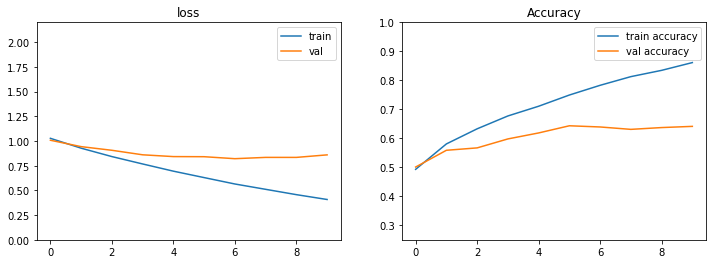

In [38]:
# Plot below your train/val loss history
# YOUR CODE HERE
# YOUR CODE HERE
# YOUR CODE HERE
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

plot_history(history, title='', axs=None, exp_name="")

# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
plt.savefig("tests/history.png")

❓ **Save your accuracy on test set as `score_test`**

In [41]:
# YOUR CODE HERE
score_test = 0.8313

🧪 **Send your results below**

In [42]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "network",
    loss = model.loss,
    input_shape = list(model.input.shape),
    layer_names = [layer.name for layer in model.layers],
    final_activation = model.layers[-1].activation.__wrapped__._keras_api_names[0],
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()